In [1]:
import os
import math
import zipfile
import time
import requests
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import imageio
import skimage.transform
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
# some stock code for downloading the images
def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"
  session = requests.Session()

  response = session.get(URL, params={ 'id': id }, stream=True)
  token = get_confirm_token(response)

  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params=params, stream=True)

  save_response_content(response, destination)

def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value
  return None

def save_response_content(response, destination, chunk_size=32*1024):
  total_size = int(response.headers.get('content-length', 0))
  with open(destination, "wb") as f:
    for chunk in tqdm(response.iter_content(chunk_size), total=total_size,
              unit='B', unit_scale=True, desc=destination):
      if chunk: # filter out keep-alive new chunks
        f.write(chunk)

def download_celeb_a(dirpath):
  data_dir = 'celebA'
  if os.path.exists(os.path.join(dirpath, data_dir)):
    print('Found Celeb-A - skip')
    return

  filename, drive_id  = "img_align_celeba.zip", "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
  save_path = os.path.join(dirpath, filename)

  if os.path.exists(save_path):
    print('[*] {} already exists'.format(save_path))
  else:
    download_file_from_google_drive(drive_id, save_path)

  zip_dir = ''
  with zipfile.ZipFile(save_path) as zf:
    zip_dir = zf.namelist()[0]
    zf.extractall(dirpath)
  os.remove(save_path)
  os.rename(os.path.join(dirpath, zip_dir), os.path.join(dirpath, data_dir))
    
download_celeb_a(r'C:\Users\liori\datasets')

Found Celeb-A - skip


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


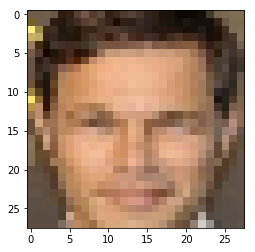

(1000, 28, 28, 3)


In [12]:
def get_image(image_path, input_height, input_width,
              resize_height=28, resize_width=28,
              crop=True):
  image = imageio.imread(image_path).astype(np.float)
  if crop:
    input_width = input_width or input_height #null handling
    crop_start_idx_h = int(round((image.shape[0] - input_height)/2.))
    crop_start_idx_w = int(round((image.shape[1] - input_width)/2.))
    image = image[crop_start_idx_h:crop_start_idx_h+input_height, crop_start_idx_w:crop_start_idx_w+input_width]    
  cropped_image = skimage.transform.resize(image, [resize_height, resize_width])
  return np.array(cropped_image)/127.5 - 1. #Normalize to [-1,1]

def show_image(image):
    plt.imshow(np.copy(image * 127.5 + 127.5).astype('uint8'), cmap='gray')
    plt.show()

def get_image_sample(path_regex, sample_size):
    image_paths = glob(path_regex)[:sample_size] #param: dataset sample size
    return np.array([get_image(image_path, 128, 108,crop=True) for image_path in image_paths]
                   ).astype(np.float32)#param: how much of center image to keep

def get_all_images_in_batches(path_regex, batch_size):
    current_index = 0
    image_paths = glob(path_regex)
    while current_index + batch_size <= len(image_paths):
        data_batch = np.array([get_image(image_path, 128, 108,crop=True) for image_path in 
                               image_paths[current_index:min(current_index+batch_size, len(image_paths))]]
                   ).astype(np.float32)
        current_index += batch_size
        yield data_batch
    
    
images = get_image_sample(r'C:\Users\liori\datasets\celebA\*.jpg', 1000)
show_image(images[32])
print(images.shape)

In [13]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = tf.keras.layers.Dense(4*4*128, use_bias=False) #1024 is a param
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.relu1 = tf.keras.layers.LeakyReLU()
    self.drop1 = tf.keras.layers.Dropout(rate=0.2) #0.2 is a param
    
    # 8x8 => 16x16 (conv size and stride only change data dependencies, not size)
    # 512 is a param
    self.conv1 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='valid', use_bias=False)
    self.batchnorm2 = tf.keras.layers.BatchNormalization()
    self.relu2 = tf.keras.layers.LeakyReLU()
    self.drop2 = tf.keras.layers.Dropout(rate=0.2)
    
    # 16x16 => 32x32 (conv size and stride only change data dependencies, not size)
    self.conv2 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
    self.relu3 = tf.keras.layers.ReLU()
    self.drop3 = tf.keras.layers.Dropout(rate=0.2)
    
     # 16x16 => 32x32 (conv size and stride only change data dependencies, not size)
    #self.conv3 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
    #self.batchnorm4 = tf.keras.layers.BatchNormalization()
    #self.relu4 = tf.keras.layers.ReLU()
    #self.drop4 = tf.keras.layers.Dropout(rate=0.2)
    
    # 32x32 => 64x64. 3 = RGB
    self.conv4 = tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False)

  def call(self, x, training=True):
    x = self.fc1(x)
    x = tf.reshape(x, shape=(-1, 4, 4, 128))
    x = self.conv1(x)
    x = self.batchnorm1(x, training=training)
    x = self.relu1(x)
    #x = self.drop1(x, training=training)

    print(x.shape)
    x = self.conv2(x)
    x = self.batchnorm2(x, training=training)
    x = self.relu2(x)
    #x = self.drop2(x, training=training)

    x = self.conv2(x)
    x = self.batchnorm3(x, training=training)
    x = self.relu3(x)
    #x = self.drop3(x, training=training)
    
    #x = self.conv3(x)
    #x = self.batchnorm4(x, training=training)
    #x = self.relu4(x)
    #x = self.drop4(x, training=training)

    x = tf.nn.tanh(self.conv4(x))  
    return x

In [14]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.lrelu1 = tf.keras.layers.LeakyReLU(alpha=0.3) #leaky alpha
    self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
    self.batchnorm2 = tf.keras.layers.BatchNormalization()
    self.lrelu2 = tf.keras.layers.LeakyReLU(alpha=0.3) #leaky alpha
    self.conv3 = tf.keras.layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same')
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
    self.lrelu3 = tf.keras.layers.LeakyReLU(alpha=0.3) #leaky alpha
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(1)

  def call(self, x, training=True):
    #x = self.lrelu1(self.batchnorm1(self.conv1(x)))
    x = self.lrelu1(self.conv1(x))
    #x = self.dropout(x, training=training)
    x = self.lrelu2(self.batchnorm2(self.conv2(x)))
    #x = self.dropout(x, training=training)
    x = self.lrelu3(self.batchnorm3(self.conv3(x)))
    #x = self.dropout(x, training=training)
    x = tf.reshape(x, (-1, 4*4*128))#self.flatten(x)
    x = self.fc1(x)
    return tf.nn.sigmoid(x)

In [15]:
generator = Generator()
discriminator = Discriminator()

# Defun gives 10 secs/epoch performance boost# Defun 
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want
    # our generated examples to look like it
    
    #smooth_factor = 0.1 #param
    #real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output)* (1 - smooth_factor), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    #generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    #total_loss = real_loss + generated_loss
    #return total_loss
    label_smoothing = 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output,
                                                labels=tf.ones_like(real_output) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output,
                                                labels=tf.zeros_like(generated_output)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss
def generator_loss(generated_output):
    #smooth_factor = 0.1 #param
    #return tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(generated_output)* (1 - smooth_factor), logits=generated_output)
    label_smoothing = 0.9
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output,
                                                labels=tf.ones_like(generated_output) * label_smoothing))
    return g_loss

discriminator_optimizer = tf.train.AdamOptimizer(2e-4,beta1=0.5)
generator_optimizer = tf.train.AdamOptimizer(2e-4,beta1=0.5)

In [16]:
EPOCHS = 3

BUFFER_SIZE = 202500
BATCH_SIZE = 64
images = get_image_sample(r'C:\Users\liori\datasets\celebA\*.jpg', min(BATCH_SIZE*EPOCHS,BUFFER_SIZE*2))
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


noise_dim = 100

def train(dataset, epochs, noise_dim):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      # generating noise from a uniform distribution
      noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        print(epoch + 1, gen_loss, disc_loss)
        print(tf.is_nan(generated_images[0,:,:,0]))
        #print('magics')
        #print(generated_images)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

      
    #if epoch % 1 == 0:
    #  display.clear_output(wait=True)
    #  generate_and_save_images(generator,
    #                           epoch + 1,
    #                           random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
    
train(train_dataset, EPOCHS, noise_dim)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(64, 11, 11, 64)
1 tf.Tensor(0.5243197, shape=(), dtype=float32) tf.Tensor(1.4976066, shape=(), dtype=float32)
tf.Tensor(
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]], shape=(88, 88), dtype=bool)
1 tf.Tensor(0.5240908, shape=(), dtype=float32) tf.Tensor(1.4982951, shape=(), dtype=float32)
tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]], shape=(88, 88), dtype=bool)
1 tf.Tensor(0.5241046, shape=(), dtype=float32) tf.Tensor(1.4981194, shape=(), dtype=float32)
tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  Tr

(1, 8, 8, 64)


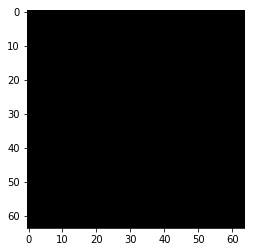

tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]], shape=(64, 64), dtype=bool)


In [11]:
num_examples_to_generate = 1
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])
result_image = generator(random_vector_for_generation, training=False)
show_image(result_image[0,:,:,:])
print(tf.is_nan(result_image[0,:,:,0]))

In [35]:
print(generator.variables)

[<tf.Variable 'dense_12/kernel:0' shape=(3, 65536) dtype=float32, numpy=
array([[ 0.00184807, -0.00246174,  0.00922283, ...,  0.00848921,
        -0.0033497 ,  0.00650632],
       [-0.00710263, -0.00738738, -0.00247419, ..., -0.00820803,
        -0.00733932,  0.00233856],
       [-0.0091548 , -0.0056524 ,  0.00709413, ...,  0.00108233,
         0.00339369,  0.00022758]], dtype=float32)>, <tf.Variable 'batch_normalization_39/gamma:0' shape=(1024,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Variable 'batch_normalization_39/beta:0' shape=(1024,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, <tf.Variable 'conv2d_transpose_21/kernel:0' shape=(5, 5, 512, 1024) dtype=float32, numpy=
array([[[[-7.34566478e-03,  1.28750782e-03,  4.32581361e-03, ...,
           6.88442308e-03, -5.74769964e-03, -4.92076902e-03],
         [-1.08819874e-02,  1.19088674e-02,  4.62886970e-03, ...,
           2.01931316e-03,  6.83691259e-03,  9.10826121e

       0.37689918, 0.3748642 ], dtype=float32)>]
